In [ ]:
#Preinstalling necessary libraries / specificated versions are necessary to avoid compatibility issues
!pip install --quiet transformers==4.5
!pip install --quiet rouge_score
!pip install --quiet pytorch-lightning
!pip install --quiet tensorflow
!pip install --quiet tensorboard
!pip install --quiet nltk

     |████████████████████████████████| 2.1 MB 4.2 MB/s 
     |████████████████████████████████| 880 kB 28.7 MB/s 
     |████████████████████████████████| 3.3 MB 6.1 MB/s 
     |████████████████████████████████| 584 kB 4.2 MB/s 
     |████████████████████████████████| 596 kB 65.0 MB/s 
     |████████████████████████████████| 140 kB 87.7 MB/s 
     |████████████████████████████████| 409 kB 65.1 MB/s 
     |████████████████████████████████| 1.1 MB 63.2 MB/s 
     |████████████████████████████████| 144 kB 77.1 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 271 kB 89.8 MB/s 
     |████████████████████████████████| 462 kB 4.1 MB/s 


In [ ]:
#importing necessary libraries and packages
import pandas as pd
import numpy as np
import logging 
import torch
from torch.utils.data import DataLoader,Dataset
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns


from dataclasses import dataclass#, field
from typing import Optional

#imoporting tokenizer and T5 model
from transformers import T5ForConditionalGeneration, T5TokenizerFast, AdamW, Trainer, TrainingArguments


from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from rouge_score import rouge_scorer

#packages and libraries for removing stopwords
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#Checking the avaliable GPUs (not necessary, made as a test of the system)
import tensorflow as tf
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)
assert num_gpus_available > 0

Num GPUs Available:  1


In [ ]:
#Importing Google Drive for reading the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Reading and clearing the data
#Vladana PATH
#df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Reviews.csv", engine="python", error_bad_lines=False)

#Vallari PATH
#df=pd.read_csv("/content/drive/MyDrive/Reviews.csv", engine="python", error_bad_lines=False)

#Katja PATH
df=pd.read_csv("/content/drive/MyDrive/DS Practical/Reviews.csv", engine="python", error_bad_lines=False)

#deleting all columns that are not usefull for training summarization model
df.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator', 'Score', 'Time'],axis=1,inplace=True)
#print("Before",len(df))
df = df.dropna() #deleting enteries without any value
#print("Data size:",len(df))
df.head() #preview of data

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
#Shortening the data for testing purposes (remove the whole cell for full training)
df1=df.loc[1:1000]  
#df.shape
#df1.shape
#print("Data size:",len(df1))

In [ ]:
#Untokenize function from
#https://github.com/commonsense/metanl/blob/master/metanl/token_utils.py
def untokenize(words):
    """
    Untokenizing a text undoes the tokenizing operation, restoring
    punctuation and spaces to the places that people expect them to be.
    Ideally, `untokenize(tokenize(text))` should be identical to `text`,
    except for line breaks.
    """
    text = ' '.join(words)
    step1 = text.replace("`` ", '"').replace(" ''", '"').replace('. . .',  '...')
    step2 = step1.replace(" ( ", " (").replace(" ) ", ") ")
    step3 = re.sub(r' ([.,:;?!%]+)([ \'"`])', r"\1\2", step2)
    step4 = re.sub(r' ([.,:;?!%]+)$', r"\1", step3)
    step5 = step4.replace(" '", "'").replace(" n't", "n't").replace(
         "can not", "cannot")
    step6 = step5.replace(" ` ", " '")
    return step6.strip()

text = df1['Text']

#Convert text to lowercase and split to a list of words
tokens=[]
for i in range(len(text)):
  oneRow=text.iloc[i]
  tokens.append(word_tokenize(oneRow.lower()))



#initializing english stopwords to remove them from each Text of review
english_stopwords = stopwords.words('english')
tokensWoStopwords=[]

#going thorugh each tokenized review text to remove all stopwords
for i in range(len(tokens)):
  tokens_wo_stopwords = [t for t in tokens[i] if t not in english_stopwords]
  #appending untokenized review Text to new list 
  #but only keeping first 512 tokens, due to model limits
  tokensWoStopwords.append(untokenize(tokens_wo_stopwords[:512]))

#print(len(tokens_wo_stopwords))


In [ ]:
#replacing Text with Text without stopwords
df1['Text']=tokensWoStopwords
df1=df1.reset_index(drop=True)
df1.head #preview of data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<bound method NDFrame.head of                                     Summary  \
0                         Not as Advertised   
1                     "Delight" says it all   
2                            Cough Medicine   
3                               Great taffy   
4                                Nice Taffy   
..                                      ...   
995  Great Hot Sauce and people who run it!   
996               this sauce is the shiznit   
997                                 Not Hot   
998                   Not hot, not habanero   
999                              best babka   

                                                  Text  
0    product arrived labeled jumbo salted peanuts.....  
1    confection around centuries. light, pillowy ci...  
2    looking secret ingredient robitussin believe f...  
3    great taffy great price. wide assortment yummy...  
4    got wild hair taffy ordered five pound bag. ta...  
..                                                 ...  
995  m

In [ ]:
#Shortened dataset split into train , validation and test dataset 
#in ratio 80/10/10
n_train = int(np.round(df1.shape[0]*0.8))
n_val = int(np.round(df1.shape[0]*0.1))
n_test = int(np.round(df1.shape[0]*0.1))
train_data=df1.loc[:n_train]
val_data=df1.loc[n_train:n_train+n_val]
test_data=df1.loc[n_train+n_val:n_train+n_val+n_test]


#Full dataset split 
#n_train = int(np.round(df.shape[0]*0.8))
#n_val = int(np.round(df.shape[0]*0.1))
#n_test = int(np.round(df.shape[0]*0.1))
#train_data=df.loc[:n_train]
#val_data=df.loc[n_train:n_train+n_val]
#test_data=df.loc[n_train+n_val:n_train+n_val+n_test]


In [ ]:
#Checking shape how dataset is splitted
#train_data.shape, test_data.shape, val_data.shape

In [ ]:
#Creating dataset shape for new T5 model for summarisation
class SummaryDataset (Dataset):
  def __init__ (
      self,
      data: pd.DataFrame,
      tokenizer: T5TokenizerFast, #initializing tokenizer
      text_max_token_len: int = 512, #setting maximum lenght of tokens for text
      summary_max_token_len: int = 128 #setting maximum lenght of tokens for summary
      ):
    self.tokenizer = tokenizer
    self.dataF = data 
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len
  
  def __len__(self):
    return len(self.dataF)

  def __getitem__(self, index: int):
    data_row = self.dataF.iloc[index]
    
    text = data_row["Text"]
    #encoding Text value to be suitable for pretrained T5 model
    text_encoding = tokenizer( 
        text,
        max_length=self.text_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"

    )
    #encoding Summary value to be suitable for pretrained T5 model
    summary_encoding = tokenizer(
        data_row["Summary"],
        max_length=self.summary_max_token_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"

    )

    labels = summary_encoding["input_ids"]
    labels[labels==0]=-100
    #reurning dictionary of tokenized Text and Summary of reviews 
    return dict(
        text=text,
        summary=data_row["Summary"],
        text_input_ids=text_encoding["input_ids"].flatten(),
        text_attention_mask=text_encoding["attention_mask"].flatten(),
        labels=labels.flatten(),
        labels_attention_mask=summary_encoding["attention_mask"].flatten()
    )



In [ ]:
# encoding train, validation and test dataset to desired input of model 
class SummaryDataModule(pl.LightningDataModule):
  def __init__(
    self,
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    val_df: pd.DataFrame,
    tokenizer: T5TokenizerFast,
    batch_size: int = 8,
    text_max_token_len: int = 512,
    summary_max_token_len: int = 128
  ):
      
    super ().__init__()
      
    self.train_df = train_df
    self.test_df = test_df
    self.val_df=val_df

    self.batch_size = batch_size
    self.tokenizer = tokenizer
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len
    
  def setup(self, stage=None) :
    self.train_dataset = SummaryDataset(
        self.train_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
        )
   
    
    self.test_dataset = SummaryDataset(
        self.test_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
        )
   
    self.val_dataset = SummaryDataset(
        self.val_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
        )

    
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=2
        )
 
  def val_dataloader(self):
   return DataLoader(
        self.val_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        )
  def test_dataloader(self):
   return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=False,
        num_workers=2
        )
   

In [ ]:
#Initialising tokenizer 
modelName="t5-small" 
 
tokenizer = T5TokenizerFast.from_pretrained(modelName)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
text_token_counts =[] 
summary_token_counts = []
#checking distribution of tokens in colums Text and Summary to get feeling about data distribution 
for _,row in train_data.iterrows():
  text_token_count = len(tokenizer.encode(row["Text"][:512])) #keeping first 512 tokenized values
  #NOTE this lenght is not the same as lenght of Text of review
  text_token_counts.append(text_token_count)

  summary_token_count = len(tokenizer.encode(row["Summary"]))
  summary_token_counts.append(summary_token_count)
  

Text(0.5, 1.0, 'summary text token counts')

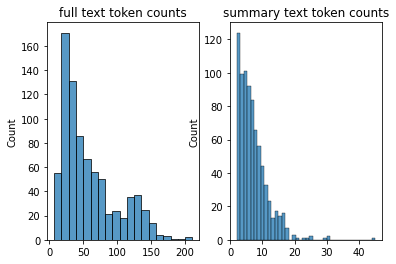

In [ ]:
#Plotting lenght of text and summaries to see how many tokens we have each
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token counts')

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title('summary text token counts')

In [ ]:
!pip install datasets==1.0. #WE DONT NEED THIS OR?

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 212 kB 77.2 MB/s 


In [ ]:
import datasets 
#rouge=datasets.load_metric("rouge")

'''
def compute_metrics(pred):
    labels_ids=pred.label_ids
    pred_ids=pred.predictions

    # all unnecessary tokens are removed
    pred_str=tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids==-100]=tokenizer.pad_token_id
    label_str=tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    print('pred_str'+str(pred_str))
    print('label_str'+str(label_str))
    rouge_output=rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision,4),
        "rouge2_recall": round(rouge_output.recall,4),
        "rouge2_fmeasure": round(rouge_output.fmeasure,4),
    }
'''

PyTorch version 1.11.0+cu113 available.
TensorFlow version 2.8.0 available.


'\ndef compute_metrics(pred):\n    labels_ids=pred.label_ids\n    pred_ids=pred.predictions\n\n    # all unnecessary tokens are removed\n    pred_str=tokenizer.batch_decode(pred_ids, skip_special_tokens=True)\n    labels_ids[labels_ids==-100]=tokenizer.pad_token_id\n    label_str=tokenizer.batch_decode(labels_ids, skip_special_tokens=True)\n    print(\'pred_str\'+str(pred_str))\n    print(\'label_str\'+str(label_str))\n    rouge_output=rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid\n\n    return {\n        "rouge2_precision": round(rouge_output.precision,4),\n        "rouge2_recall": round(rouge_output.recall,4),\n        "rouge2_fmeasure": round(rouge_output.fmeasure,4),\n    }\n'

In [ ]:
#Training parameters set up
N_EPOCHS = 3 #try more epochs, eg. 10 <-- whether it decreases, shows plateau

TRAIN_BATCH_SIZE = 16 
BATCH_SIZE=16

#initializing data_module with train, test, validation dataset and tokenizer
data_module=SummaryDataModule(train_data,test_data,val_data,tokenizer,batch_size=BATCH_SIZE)

### Model


In [ ]:
#creating T5 model for summarization 
class SummaryModel(pl.LightningModule):

 def __init__(self):
   super().__init__()
   #initializing model
   self.model = T5ForConditionalGeneration.from_pretrained(modelName, return_dict=True) 
   self.rouge_metric = load_metric('rouge') 
        
 #defining forward function and it output
 def forward(self,input_ids, attention_mask, decoder_attention_mask, labels=None):
   output = self.model(
      input_ids,
      attention_mask=attention_mask,
      labels=labels,
      decoder_attention_mask=decoder_attention_mask
    )
   return output.loss, output.logits

 
 def training_step(self, batch, batch_idx):
   input_ids = batch[ "text_input_ids"]
   attention_mask = batch["text_attention_mask"]
   labels = batch["labels"]
   labels_attention_mask = batch["labels_attention_mask"]
  
   loss, outputs = self(
     input_ids=input_ids,
     attention_mask=attention_mask,
     decoder_attention_mask=labels_attention_mask,
     labels=labels
    )
   self.log("train loss", loss, prog_bar=True,logger=True)
   return loss


 def validation_epoch_end(self, outputs):
        outputs = str(outputs)
        
        #avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        #tensorboard_logs = {"val_loss": avg_loss}
        
        rouge_results = self.rouge_metric.compute() 
        rouge_dict = self.parse_score(rouge_results)
    
        
        tensorboard_logs = {"Rougue1": rouge_results['rouge1']}
        tensorboard_logs.update(rouge1=rouge_dict['rouge1'], rougeL=rouge_dict['rougeL'])
        ## Clear out the lists for next epoch
        self.target_gen= []
        self.prediction_gen=[]
        self.log("rougue1", rouge_results['rouge1'], prog_bar=True,logger=True)
        return {"rouge1" : rouge_results['rouge1'],
                "rougeL" : rouge_results['rougeL']}

 def test_step(self, batch, batch_idx):
   input_ids = batch[ "text_input_ids"]
   attention_mask = batch["text_attention_mask"]
   labels = batch["labels"]
   labels_attention_mask = batch["labels_attention_mask"]
  
   loss, outputs = self(
     attention_mask=attention_mask,
     decoder_attention_mask=labels_attention_mask,
     labels=labels
    )
   self.log("test_loss", loss, prog_bar=True,logger=True)
   return loss

#configurating optimizer as most used one AdamW
 def configure_optimizers(self):
    return AdamW(self.parameters(), lr=0.0001) #early_stopping: parameter to adapt the learning rate depending on the training results

In [ ]:
from datasets import load_metric
metric = load_metric("rouge")

def calc_rouge_scores(candidates, references):
    result = metric.compute(predictions=candidates, references=references, use_stemmer=True)
    result = {key: round(value.mid.fmeasure * 100, 1) for key, value in result.items()}
    return result

In [ ]:
model=SummaryModel()

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242M [00:00<?, ?B/s]

NameError: ignored

In [ ]:
#loading tensorboard
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

In [ ]:
#creating checkpoint_callback for the model
#and setting which function we are monitoring
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints", 
  filename="best-checkpoint", 
  save_top_k=1,
  verbose=True,
  monitor="rouge1",
  mode="min"
)

#initializing logger
logger = TensorBoardLogger("lightning_logs", name="our-summary")

#initializing trainer
trainer = pl.Trainer(
  logger=logger,
  enable_checkpointing=checkpoint_callback,
  #compute_metrics=compute_metrics,
  max_epochs=N_EPOCHS,
  gpus=1,
  enable_progress_bar=True
)

In [ ]:
trainer.fit(model,data_module) #training model

In [ ]:
#saving trained model 
trained_model = SummaryModel.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()

In [ ]:
#defining function which will generate summaries 
def summarize (text):
  text_encoding = tokenizer(
    text,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
  )
  generated_ids = trained_model.model.generate(
    input_ids=text_encoding["input_ids"],
    attention_mask=text_encoding["attention_mask"],
    max_length=200,
    num_beams=2,
    repetition_penalty=2.5,
    length_penalty=1.0,
    early_stopping=True
  ) 
  
  preds =[
    tokenizer.decode (gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    for gen_id in generated_ids
  ]
  
  return "". join(preds)


In [ ]:
#creating new dataset with old summary and new generated summary 
test_data = test_data.reset_index()
for i in range(0,len(test_data)):
  test_data['Generated_summary'] = ""
  test_data['Rogue'] = ''
test_data.head()


In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
for i in range (10): #replace with len(test_data)
  sample_row = test_data.iloc[i]
  text = sample_row["Text"]
  model_summary = summarize(text)
  test_data["Generated_summary"][i] = model_summary
  scores = scorer.score(text,model_summary)
  test_data['Rogue'][i] = scorer.score(text,model_summary)


In [ ]:
test_data.head() #preview of data

In [ ]:
#saving generated summaries as new csv file 
test_data.to_csv("/content/drive/MyDrive/summary_test.csv") 

In [ ]:
#sample_row = test_data.iloc[6]
#text = sample_row["Text" ]
#model_summary = summarize(text)

In [ ]:
#summary = sample_row["Summary"]
#print(summary)
#print(model_summary)

In [ ]:
#Calculate and print out rouge scores
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(text,model_summary)
scores

In [ ]:
!pip install datasets==1.0

In [ ]:
ref_summaries = list(test_data['Summary'])

for i in range (len(test_data)): #len(test_data)
  candidate_summaries = list(test_data['Generated_summary'])
  print(f"First {i+1} sentence(s): Scores {calc_rouge_scores(candidate_summaries, ref_summaries)}")

In [ ]:
#This is how logger is defined
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
            metrics = trainer.callback_metrics
            # Log results
            for key in sorted(metrics):
                if key not in ["log", "progress_bar"]:
                    logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
            metrics = trainer.callback_metrics

            # Log and save results to file
            output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
            with open(output_test_results_file, "w") as writer:
                for key in sorted(metrics):
                    if key not in ["log", "progress_bar"]:
                        logger.info("{} = {}\n".format(key, str(metrics[key])))
                        writer.write("{} = {}\n".format(key, str(metrics[key])))